In [ ]:
import os
import numpy as np
import rasterio
from PIL import Image
import albumentations as A

# Input paths
stacked_img_dir = r"C:\Users\wasif\Desktop\Annotated Images\stacked"
resized_mask_dir = r"C:\Users\wasif\Desktop\Annotated Images\masks_resized"

# Output paths
aug_img_dir = r"C:\Users\wasif\Desktop\Augmented_Full\images"
aug_mask_dir = r"C:\Users\wasif\Desktop\Augmented_Full\masks"
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_mask_dir, exist_ok=True)

# Augmentation config
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, border_mode=0, p=0.4)
])

N_AUGS = 5

# Loop through all stacked images
for filename in os.listdir(stacked_img_dir):
    if filename.endswith("_stacked.jp2"):
        base_id = filename.replace("_stacked.jp2", "")
        img_path = os.path.join(stacked_img_dir, filename)
        mask_path = os.path.join(resized_mask_dir, f"{base_id}_annotated_resized.png")

        if not os.path.exists(mask_path):
            print(f"❌ Mask not found for {base_id}, skipping.")
            continue

        with rasterio.open(img_path) as src:
            img_stack = src.read()  # (bands, H, W)
            meta = src.meta

        img_np = np.moveaxis(img_stack, 0, -1)
        mask_np = np.array(Image.open(mask_path).convert("L"))

        for i in range(N_AUGS):
            augmented = transform(image=img_np, mask=mask_np)
            aug_img = np.moveaxis(augmented["image"], -1, 0)
            aug_mask = (augmented["mask"] > 127).astype(np.uint8) * 255

            # NDWI category
            B3 = aug_img[2]
            B8 = aug_img[7]
            ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
            ndwi_ratio = np.sum(ndwi > 0.1) / ndwi.size
            land_ratio = np.sum(ndwi < -0.1) / ndwi.size

            if ndwi_ratio > 0.7:
                label = "water"
            elif land_ratio > 0.7:
                label = "land"
            else:
                label = "mixed"

            # Save image as JP2 to save space
            aug_img_path = os.path.join(aug_img_dir, f"{base_id}_{label}_aug{i}.jp2")
            with rasterio.open(
                aug_img_path, "w",
                driver="JP2OpenJPEG",
                height=aug_img.shape[1],
                width=aug_img.shape[2],
                count=aug_img.shape[0],
                dtype=aug_img.dtype,
                crs=meta["crs"],
                transform=meta["transform"]
            ) as dst:
                dst.write(aug_img)

            # Save mask
            aug_mask_path = os.path.join(aug_mask_dir, f"{base_id}_{label}_aug{i}.png")
            Image.fromarray(aug_mask).save(aug_mask_path)

            print(f"✅ Saved {label}: {aug_img_path}")

print("\n🎉 All images processed and augmented!")


C:\Users\wasif\AppData\Local\Temp\2\ipykernel_1176\253558576.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wasif\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


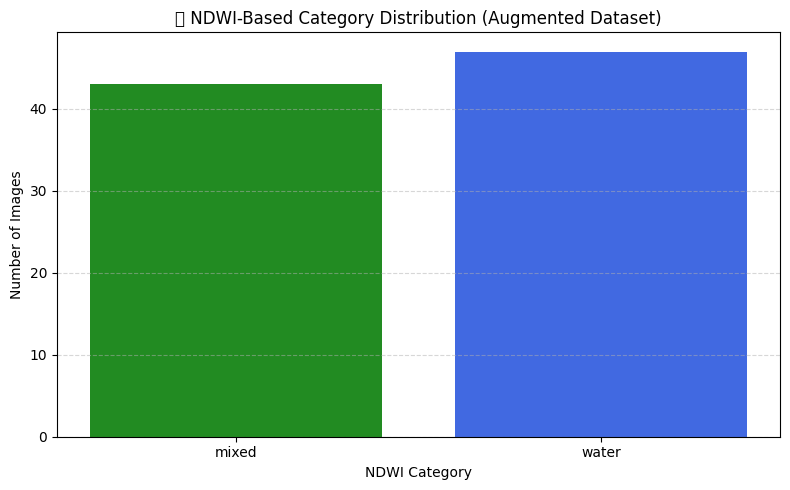

In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# 🔁 Update this path to your actual output image directory
aug_img_dir = r"C:\Users\wasif\Desktop\Augmented_Full\images"

# Count filenames by NDWI label in filename
counts = Counter()
for fname in os.listdir(aug_img_dir):
    if fname.endswith(".jp2"):
        if "land" in fname:
            counts["land"] += 1
        elif "water" in fname:
            counts["water"] += 1
        elif "mixed" in fname:
            counts["mixed"] += 1

# Prepare data for plotting
labels = list(counts.keys())
values = [counts[label] for label in labels]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['forestgreen', 'royalblue', 'goldenrod'])
plt.title("📊 NDWI-Based Category Distribution (Augmented Dataset)")
plt.xlabel("NDWI Category")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
